<a href="https://colab.research.google.com/github/ohashi-gnct/exp/blob/2023/3%E5%B9%B4%E7%94%9F%E3%83%87%E3%83%BC%E3%82%BF%E3%82%B5%E3%82%A4%E3%82%A8%E3%83%B3%E3%82%B9%E6%BC%94%E7%BF%92_A_google%E6%A4%9C%E7%B4%A2%E6%95%B0%E3%81%A8%E3%82%B3%E3%83%AD%E3%83%8A%E6%84%9F%E6%9F%93%E8%80%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import os
import io
import json
import datetime as dt

import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

Colabに最初から入っていないライブラリをUNIXコマンドの`pip`で導入する。

`japanize-matplotlib`は日本語でmatplotlibが使えるようにするライブラリである。

In [12]:
!pip install japanize-matplotlib

In [13]:
# matplotlibの日本語化
import japanize_matplotlib
%matplotlib inline
sns.set(font="IPAexGothic")

Googleドライブを接続し、CSVファイルを自分のドライブに保存する。

認証を求める画面が出る場合がある。

自身でJupyter notebook環境を作っている場合、ディレクトリは適当に読み替えること。

In [14]:
# Googleドライブの接続
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
drive_path = '/content/drive/MyDrive'

Mounted at /content/drive


プロットの見栄えがするように初期設定する。

In [15]:
# matplotlibの初期設定
plt_config = {
    "figure.dpi": 150,
    "font.size": 14,
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "mathtext.cal": "serif",
    "mathtext.rm": "serif",
    "mathtext.it": "serif:italic",
    "mathtext.bf": "serif.bold",
    "mathtext.fontset": "cm",
    "legend.framealpha": 1.0,
    "legend.edgecolor": "black",
    "legend.fancybox": False
}
plt.rcParams.update(plt_config)

# Google検索

特定の検索ワードについて、その検索数の推移を取得できる。

値は検索回数ではなく、検索回数の最大が100になるようスケールされた数である。

https://smart-hint.com/python/pytrends/

In [16]:
!pip install pytrends

In [17]:
from pytrends.request import TrendReq
pytrends = TrendReq(hl='ja-JP', tz=-540)

2023-10-09から過去3年間について、キーワードの検索数の推移を取得する。

このとき、取得できるデータは週単位で集計されていることに注意する。

期間を270日以下にすれば、日ごとのデータが取得できる。

注意：日付の範囲を変えると、週ごとのデータの開始日が変わるため、<br>
wikipediaアクセス数のデータを週ごとにまとめた時indexが整合しないことがある。

In [50]:
kw_list = ['高専'] # キーワードのリスト（5個まで）
# 開始、終了日を記述
pytrends.build_payload(kw_list=kw_list,
                       timeframe='2020-10-10 2023-10-09',
                       geo='JP')
df_trends = pytrends.interest_over_time()
df_trends = df_trends.drop('isPartial',axis=1)
df_trends

,高専
date,
2020-10-11,52
2020-10-18,51
2020-10-25,55
2020-11-01,50
2020-11-08,49
...,...
2023-09-03,46
2023-09-10,47
2023-09-17,53


<Axes: xlabel='date'>

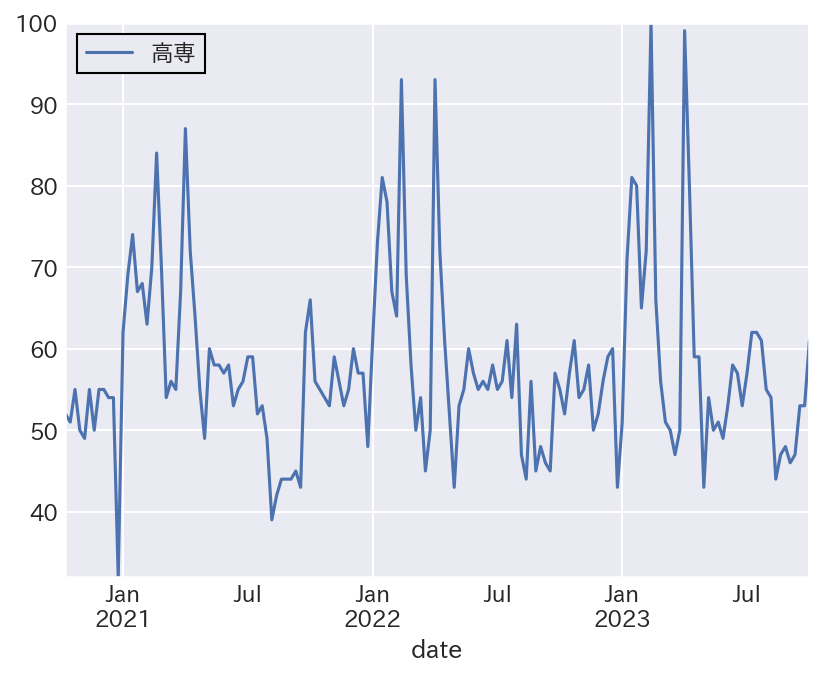

In [51]:
df_trends.plot()

データはCSVファイルとして保存する。

In [43]:
df_trends.to_csv(os.path.join(drive_path, "trends.csv"))

In [44]:
# 保存したCSVファイルを読み込みたい場合、以下のように記述する。
# df_trends = pd.read_csv(os.path.join(drive_path, "trends.csv"))
# df_trends["date"] = pd.to_datetime(df_trends["date"])
# df_trends = df_trends.set_index("date")

# Wikipedia アクセス数

Wikipedia Pageview APIを使用して、日ごとの特定のページのアクセス数を取得する。

特定のページにアクセスすることで、JSONファイルを取得できる。

curlコマンドでWebアクセスを行う。

In [45]:
import urllib.parse

In [52]:
title = "高等専門学校"
start_date = "20201010"
end_date = "20231009"

# 日本語をURLエンコードする
title_quote = urllib.parse.quote(title)
# APIのURL
wikipedia_URL = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/ja.wikipedia.org/all-access/all-agents/' + title_quote + '/daily/'+ start_date + '/' + end_date
wikipedia_file_path = os.path.join(drive_path, 'wikipedia.json')

In [53]:
# APIにアクセスし、リダイレクトでファイルに保存する
!curl -X GET --header 'Accept: application/json; charset=utf-8' $wikipedia_URL > $wikipedia_file_path

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  170k    0  170k    0     0   269k      0 --:--:-- --:--:-- --:--:--  270k


In [59]:
# JSONファイルを読み取り、日ごとの閲覧数をdataframeにする
df_wikipedia = pd.read_json(wikipedia_file_path)
df_wikipedia = pd.json_normalize(df_wikipedia['items'])
df_wikipedia['timestamp'] = pd.to_datetime(df_wikipedia['timestamp'], format='%Y%m%d%H')
df_wikipedia['date'] = df_wikipedia['timestamp']
df_wikipedia = df_wikipedia[['date', 'views']]
df_wikipedia

,date,views
0,2020-10-10,498
1,2020-10-11,572
2,2020-10-12,622
3,2020-10-13,587
4,2020-10-14,521
...,...,...
1089,2023-10-04,482
1090,2023-10-05,463
1091,2023-10-06,401
1092,2023-10-07,286


<Axes: xlabel='date'>

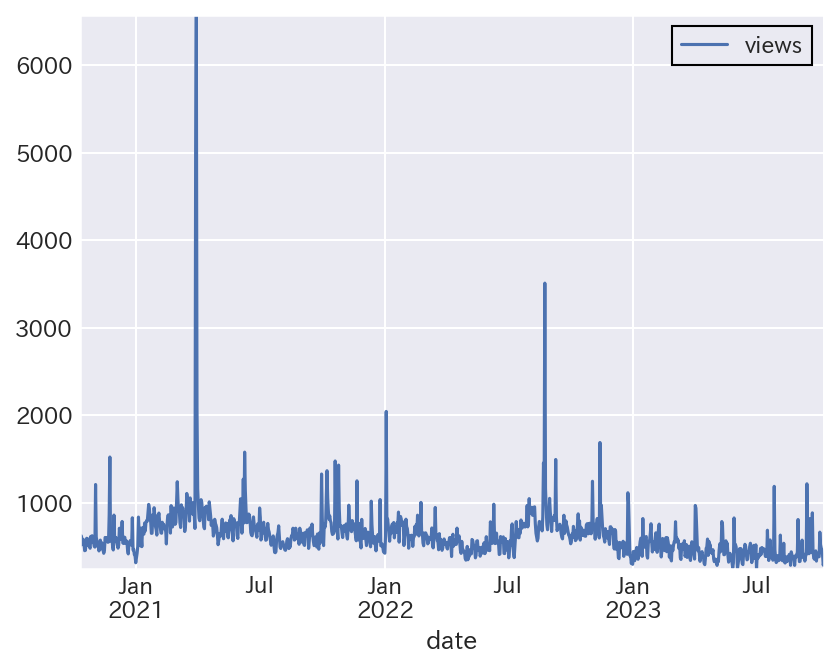

In [61]:
df_wikipedia.set_index('date').plot()

# 相関関係の分析

上のデータから任意の2データを選び、相関関係を分析する。

2つのDataFrameを結合したいが、Googleトレンドは週単位、

Wikipediaアクセス数は日単位になっているため、週単位に揃える。

Wikipediaアクセス数のデータについて、1週間ごとの平均をとる。

In [62]:
# 日曜日を始まりとして、1週間ごとの平均をとる
df_wikipedia_weekly = df_wikipedia.groupby(pd.Grouper(key='date', freq='W-SUN')).mean().reset_index()
df_wikipedia_weekly = df_wikipedia_weekly.set_index("date")
df_wikipedia_weekly

,views
date,
2020-10-11,535.000000
2020-10-18,535.285714
2020-10-25,533.142857
2020-11-01,558.000000
2020-11-08,617.000000
...,...
2023-09-10,409.428571
2023-09-17,629.571429
2023-09-24,495.142857


DataFrameを結合する。

`index`つまり`date`が共通の列だけを結合した新たなDataFrameを作る。

In [64]:
# 2つのdfでindexが共通の列だけを結合する
df_concat = pd.concat([df_trends, df_wikipedia_weekly], axis=1, join="inner")
df_concat

,高専,views
date,,
2020-10-11,52,535.000000
2020-10-18,51,535.285714
2020-10-25,55,533.142857
2020-11-01,50,558.000000
2020-11-08,49,617.000000
...,...,...
2023-09-03,46,448.142857
2023-09-10,47,409.428571
2023-09-17,53,629.571429


それぞれの変数をプロットしてみる。

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

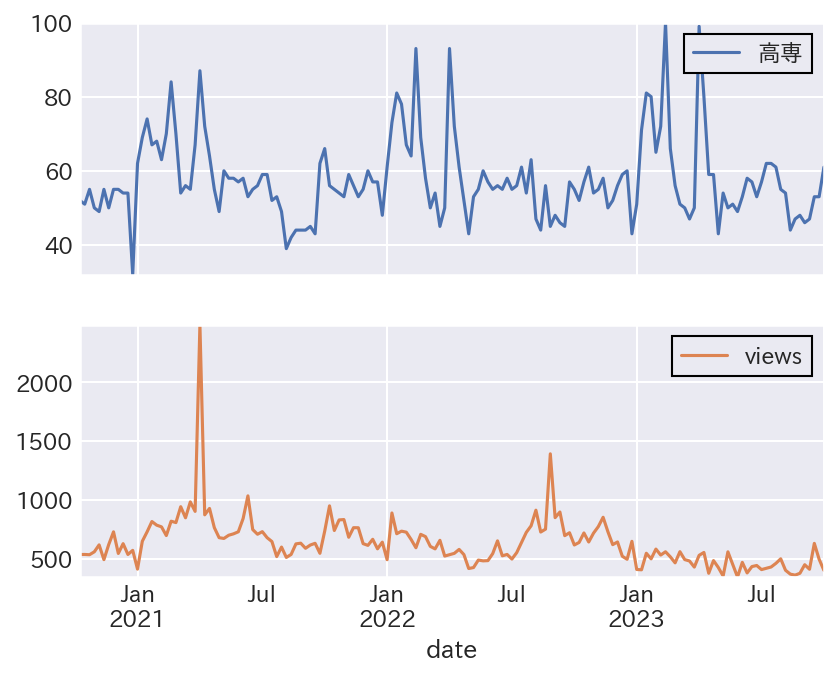

In [65]:
df_concat.plot(subplots=True)

matplotlibのラッパーである`seaborn`ライブラリを使って、

すべての組み合わせの2変数で散布図を作成できる。

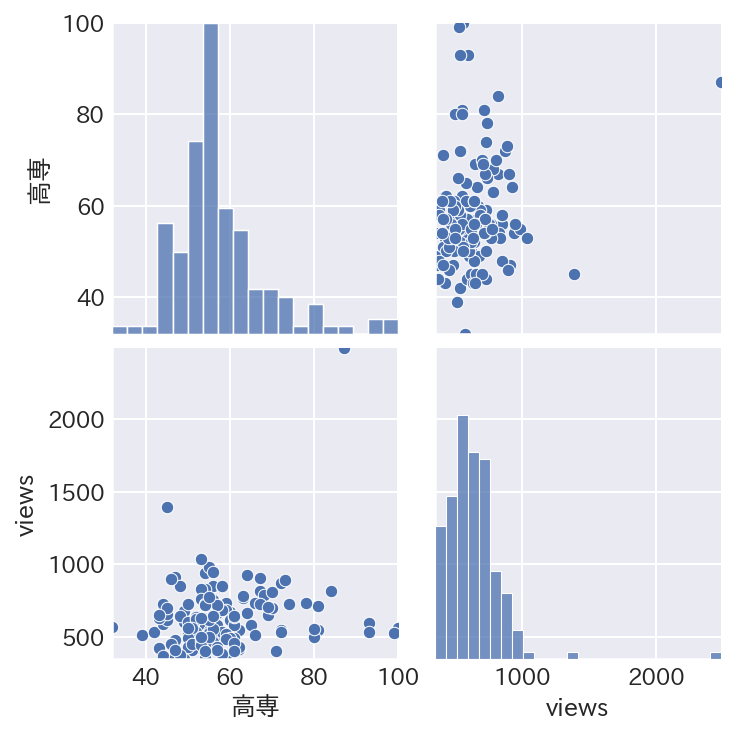

In [66]:
sns.pairplot(df_concat)

散布図を描くことで、2変数がどのように関係しているか直感的に確認できる。

この図をもとに考察してもよい。

これらの相関係数を求める。

3変数以上ある場合にも、相互に相関係数を求められる。

<Axes: >

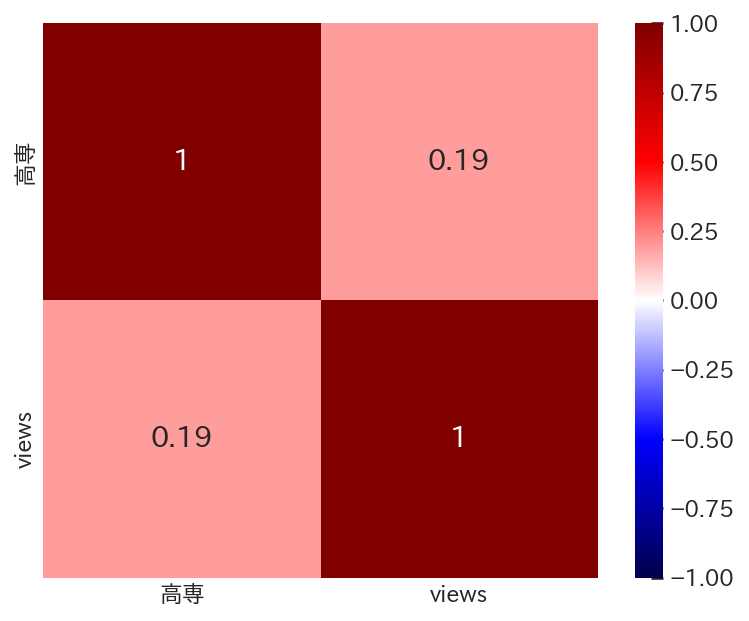

In [67]:
corr = df_concat.corr()
sns.heatmap(corr, vmax=1, vmin=-1, center=0,
            cmap="seismic", square=True, annot=True)

2変数の間にはあまり相関がないことがわかる。

# 単回帰分析

任意の1変数を目的変数(y軸)、別の任意の1変数を説明変数(x軸)として、

単回帰分析を行う。

まず、機械学習のためのライブラリscikit-learnから

単回帰分析のためのモジュールを読み込む。

In [68]:
from sklearn import linear_model

In [70]:
clf = linear_model.LinearRegression()
X = df_concat[["高専"]]
Y = df_concat[["views"]]
clf.fit(X, Y)

print("回帰係数: " + str(clf.coef_))
print("切片: " + str(clf.intercept_))
print("決定係数: " + str(clf.score(X, Y)))

回帰係数: [[3.8495731]]
切片: [410.29442972]
決定係数: 0.03759291333660231


決定係数は非常に低いため、このモデルでは目的変数を十分に説明できているわけではない。

最小二乗法による回帰では外れ値の影響を強く受けるため、外れ値についても検討する必要がある。

回帰直線を散布図に重ねて描くと以下のようになる。

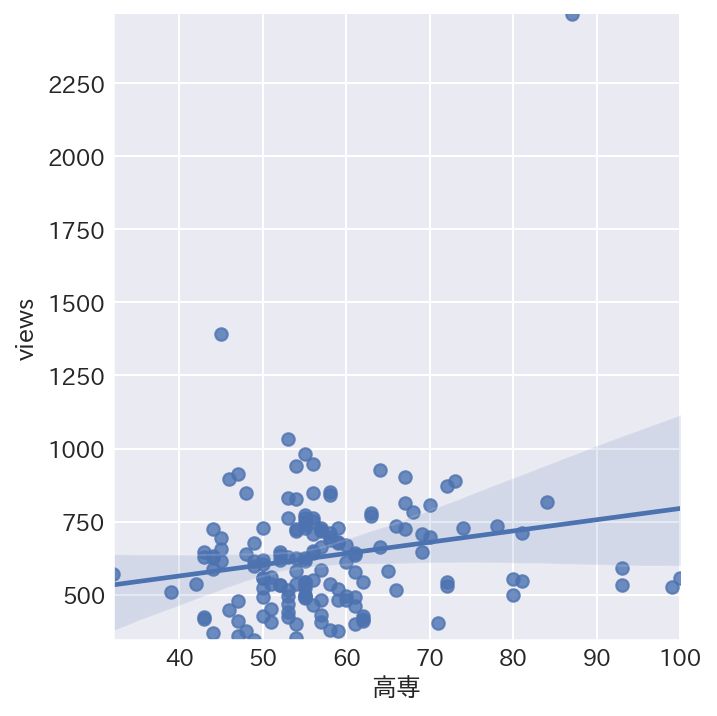

In [72]:
sns.lmplot(x="高専", y="views", data=df_concat)

グラフからも、単回帰によって十分に目的変数を説明できないことがわかる。